<a href="https://colab.research.google.com/github/Manikanta-GB/FinalSemProject/blob/main/uber_pickups_nyc_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import time

from datetime import datetime
from collections import Counter

from pandas.plotting import autocorrelation_plot as acp
from statsmodels.graphics.tsaplots import plot_pacf

RNN and LSTM

In [7]:
uber_jan_june = pd.read_csv("/content/drive/MyDrive/UberPickUpDemandProject/archive/uber-raw-data-janjune-15.csv")
print (uber_jan_june.head())
uber_jan_june.shape

  Dispatching_base_num          Pickup_date Affiliated_base_num  locationID
0               B02617  2015-05-17 09:47:00              B02617         141
1               B02617  2015-05-17 09:47:00              B02617          65
2               B02617  2015-05-17 09:47:00              B02617         100
3               B02617  2015-05-17 09:47:00              B02774          80
4               B02617  2015-05-17 09:47:00              B02617          90


(14270479, 4)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:

uber_jan_june['Month_Day'] = uber_jan_june['Pickup_date'].apply(lambda pickup: datetime.strptime(pickup, '%Y-%m-%d %H:%M:%S').strftime('%m-%d').split('-'))

In [9]:
## Separate month and day
uber_jan_june['Month'] = [month_day [0] for month_day in uber_jan_june['Month_Day']]
uber_jan_june['Day'] = [month_day [1] for month_day in uber_jan_june['Month_Day']]
uber_jan_june.tail(20)

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID,Month_Day,Month,Day
14270459,B02765,2015-05-08 15:40:00,B02765,186,"[05, 08]",05,08
14270460,B02765,2015-05-08 15:41:00,B02764,50,"[05, 08]",05,08
14270461,B02765,2015-05-08 15:41:00,B02253,13,"[05, 08]",05,08
14270462,B02765,2015-05-08 15:41:00,B02682,192,"[05, 08]",05,08
14270463,B02765,2015-05-08 15:41:00,B02345,262,"[05, 08]",05,08
14270464,B02765,2015-05-08 15:41:00,B02765,237,"[05, 08]",05,08
14270465,B02765,2015-05-08 15:41:00,B02765,233,"[05, 08]",05,08
14270466,B02765,2015-05-08 15:41:00,B02765,148,"[05, 08]",05,08
14270467,B02765,2015-05-08 15:41:00,B02765,33,"[05, 08]",05,08
14270468,B02765,2015-05-08 15:42:00,B02096,232,"[05, 08]",05,08


In [10]:
jan_june_grouped = uber_jan_june.groupby(by = ['Month', 'Day']).size().unstack()
jan_june_grouped

Day,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01,58045.0,40287.0,59844.0,41943.0,43678.0,53539.0,63375.0,73016.0,72124.0,80656.0,58751.0,58991.0,64765.0,64725.0,68211.0,74193.0,75364.0,74523.0,47025.0,55867.0,60383.0,66819.0,73363.0,82588.0,59382.0,44310.0,25954.0,61626.0,70441.0,85565.0,94448.0
02,78592.0,70193.0,71532.0,68237.0,82336.0,87568.0,82752.0,64327.0,63306.0,66197.0,73742.0,84751.0,99897.0,102347.0,91320.0,73672.0,74221.0,73493.0,90271.0,102762.0,100481.0,67844.0,72494.0,80520.0,75992.0,84840.0,90217.0,89716.0,NaN,NaN,NaN
03,70839.0,57460.0,75048.0,71931.0,77446.0,83134.0,81468.0,61824.0,53920.0,72185.0,65315.0,74038.0,79272.0,90956.0,63421.0,54824.0,62886.0,70384.0,75839.0,95273.0,80745.0,69337.0,60498.0,64400.0,73953.0,78552.0,84977.0,92527.0,75648.0,62780.0,78893.0
04,69223.0,74069.0,75983.0,69189.0,58357.0,53565.0,68079.0,72023.0,77520.0,81439.0,82547.0,67726.0,56655.0,63393.0,66534.0,78808.0,83855.0,94196.0,78107.0,78076.0,68712.0,82124.0,92110.0,99688.0,106270.0,88673.0,64783.0,68863.0,75940.0,84330.0,NaN
05,92329.0,104978.0,80300.0,65447.0,76195.0,80447.0,87361.0,90733.0,98359.0,80146.0,70310.0,78437.0,84937.0,93624.0,99756.0,121557.0,94322.0,76414.0,85371.0,91062.0,95146.0,85771.0,78343.0,68328.0,59748.0,72820.0,88662.0,95074.0,98200.0,104429.0,96947.0
06,93499.0,97592.0,87206.0,95023.0,101922.0,101773.0,88876.0,76899.0,82463.0,87403.0,102013.0,103052.0,101170.0,90856.0,85857.0,89171.0,93706.0,99842.0,101703.0,101667.0,89285.0,75418.0,93172.0,91388.0,100073.0,99508.0,136193.0,93108.0,74430.0,82627.0,NaN


In [11]:
## Aggregate results to form a time-series
all_jan_june = [jan_june_grouped.iloc[r,:] for r in range(jan_june_grouped.shape[0])]
all_jan_june = [trips for month in all_jan_june for trips in month]
len(all_jan_june)

186

In [12]:
## Remove missing values: here missing values are the days when a month is shorter than 31 days.
remove_inds = list(np.argwhere(np.isnan(all_jan_june) == True).reshape((1,5))[0])
all_jan_june_mod = [all_jan_june[i] for i,j in enumerate(all_jan_june) if i not in remove_inds]

In [13]:
## Convert time-series into data-frame for modeling process
uber_jan_june_final = pd.DataFrame({'Days': range(1,len(all_jan_june_mod)+1), 'Trips': all_jan_june_mod})
uber_jan_june_final.head()

,Days,Trips
0,1,58045.0
1,2,40287.0
2,3,59844.0
3,4,41943.0
4,5,43678.0


## Pre-processing data for RNN-LSTM

In [14]:
from sklearn.preprocessing import MinMaxScaler

## Split into train-test set:
train_jan_june = uber_jan_june_final.iloc[0:167,1:2].values
test_jan_june = uber_jan_june_final.iloc[167:,1:2].values

print ('Training data: ', train_jan_june.shape)
print ('Testing data: ', test_jan_june.shape)

## Feature-scaling:
mms = MinMaxScaler(feature_range = (0,1))
train_jan_june_scaled = mms.fit_transform(train_jan_june)

Training data:  (167, 1)
Testing data:  (14, 1)


In [15]:
x_train = []
y_train = []

for rides in range(14, 167):
    x_train.append(train_jan_june_scaled[rides-14:rides,0])
    y_train.append(train_jan_june_scaled[rides,0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, newshape = (x_train.shape[0], x_train.shape[1], 1))

## Build RNN:

In [16]:
## Import required modules:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import GridSearchCV

### Parameters for LSTM:
1. num_units = 40
2. drpout = 0.2
3. epochs = 1000
4. size_of_batch = 16
5. optimizer = 'adam'
6. loss = 'mean_squared_error'

In [17]:
np.random.seed(11)
t_start = time.time()

def build_rnn(num_units, input_x, input_y, drpout, epochs, size_of_batch, optimizer, loss):
    
    regressor = Sequential()

    ## Adding first LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True, input_shape = (input_x.shape[1],1)))
    regressor.add(Dropout(drpout))

    ## Adding second LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding third LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding fourth LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(drpout))

    ## Adding fifth LSTM layer:
    regressor.add(LSTM(units = num_units, return_sequences = False))
    regressor.add(Dropout(drpout))

    ## Adding o/p layer:
    regressor.add(Dense(units = 1))

    ## Compiling RNN:
    regressor.compile(optimizer = optimizer, loss = loss)

    ## Fitting RNN to training set:
    regressor.fit(x = input_x, y = input_y, epochs = epochs, batch_size = size_of_batch)

    return regressor
    
regressor = build_rnn(num_units = 40, input_x = x_train, input_y = y_train, drpout = 0.2, epochs = 1000, size_of_batch = 16, optimizer = 'adam', loss = 'mean_squared_error')

print (time.time() - t_start)

Epoch 1/1000
10/10 [==============================] - 9s 33ms/step - loss: 0.1993
Epoch 2/1000
10/10 [==============================] - 0s 38ms/step - loss: 0.0410
Epoch 3/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0282
Epoch 4/1000
10/10 [==============================] - 0s 39ms/step - loss: 0.0280
Epoch 5/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0263
Epoch 6/1000
10/10 [==============================] - 0s 41ms/step - loss: 0.0218
Epoch 7/1000
10/10 [==============================] - 0s 43ms/step - loss: 0.0239
Epoch 8/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.0245
Epoch 9/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0231
Epoch 10/1000
10/10 [==============================] - 0s 37ms/step - loss: 0.0220
Epoch 11/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.0247
Epoch 12/1000
10/10 [==============================] - 0s 36ms/step - loss: 0.0212
Epoch 13/1000

In [18]:
adjusted_inputs = uber_jan_june_final[len(uber_jan_june_final) - len(test_jan_june) - 14:]['Trips'].values
adjusted_inputs = adjusted_inputs.reshape(-1,1)
adjusted_inputs = mms.transform(adjusted_inputs)
adjusted_inputs[0:10]

array([[0.64069119],
       [0.72245641],
       [0.79461942],
       [0.79306089],
       [0.65815926],
       [0.53288077],
       [0.59107978],
       [0.6427518 ],
       [0.79557127],
       [0.80643913]])

In [19]:
## Create properly structured test set:
x_test = []
for rides in range(14,29):
    x_test.append(adjusted_inputs[rides-14:rides,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, newshape = (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(15, 14, 1)

In [20]:
## Make prediction for test set and bring values back to original scale
pred = regressor.predict(x_test)
pred = mms.inverse_transform(pred)

## Check RMSE on test-set
residuals = pred[0:-1] - test_jan_june
rmse = np.sqrt(np.mean(residuals**2))
rmse

11974.223743010132

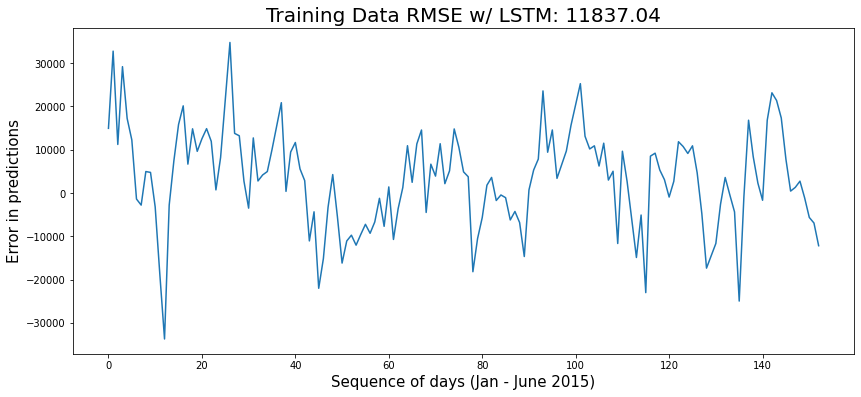

In [21]:
pred_train = regressor.predict(x_train)
pred_train = mms.inverse_transform(pred_train)

residuals_train = pred_train - train_jan_june[0:-14]
rmse_train = np.sqrt(np.mean(residuals_train**2))

fig, ax = plt.subplots(figsize = (14,6))
ax.plot(residuals_train)
ax.set_xlabel('Sequence of days (Jan - June 2015)', fontsize = 15)
ax.set_ylabel('Error in predictions', fontsize = 15)
ax.set_title('Training Data RMSE w/ LSTM: {}'.format(round(rmse_train,3)), fontsize = 20)
plt.show()